In [2]:
MAKE_BOOK_FIGURES=False
import numpy as np
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

In [ ]:
!pip install gpytorch

import torch
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel

class ExactGP(gpytorch.models.ExactGP):
    """Exact Gaussian Process model.

    Arguments
    train_x     --  The training inputs.
    train_y     --  The training labels.
    mean_module --  The mean module. Defaults to a constant mean.
    covar_module--  The covariance module. Defaults to a RBF kernel.
    likelihood  --  The likelihood function. Defaults to Gaussian.
    """

    def __init__(
            self,
            train_x,
            train_y,
            mean_module=gpytorch.means.ConstantMean(),
            covar_module = ScaleKernel(RBFKernel()),
            likelihood=gpytorch.likelihoods.GaussianLikelihood(
                noise_constraint=gpytorch.constraints.GreaterThan(0.0)
            )
    ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )
    
    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )
    
    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label=r'$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )

    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )
        
    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star,
            f_post_samples.T.detach(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )
        
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return m_star, v_star

def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None
):
    """Plot the information acquisition function.
    
    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
              
    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    
    The evaluation of the information acquisition function
    is as follows:
    
        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )
    
    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )
    
    sigma = torch.sqrt(v)
    af_values = alpha(m, sigma, Y.max(), **alpha_params)
    next_id = torch.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]
    
    ax2 = ax.twinx()
    ax2.plot(x_star, af_values.detach(), color=sns.color_palette()[1])
    ax2.set_ylabel(
        'Maximum Upper Interval',
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        torch.linspace(0, af_max.item(), 100),
        color=sns.color_palette()[1],
        linewidth=1
    )

def maximize(
    f,
    model,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.
    
    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowledge.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
    
    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.
                    
    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        f_design = model(X_design)
        m = f_design.mean
        sigma2 = f_design.variance
        sigma = torch.sqrt(sigma2)
        
        # Evaluate information acquisition function
        y_train = model.train_targets.numpy()
        af_values = alpha(
            m,
            sigma,
            y_train.max(),
            **alpha_params
        )
        
        # Find best point to include
        i = torch.argmax(af_values)
        af_all.append(af_values[i])
        
        new_x = X_design[i:(i+1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)

        if optimize:
            train(model, train_x, train_y, n_iter=100, lr=0.1)
        else:
            model.train()
            model.eval()
        
        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                model,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all


# Expected Improvement

We develop intuition about the expected improvement, the most popular acquisition function for Bayesian optimization.
Let's reintroduce the same running example as the previous hands-on activity.

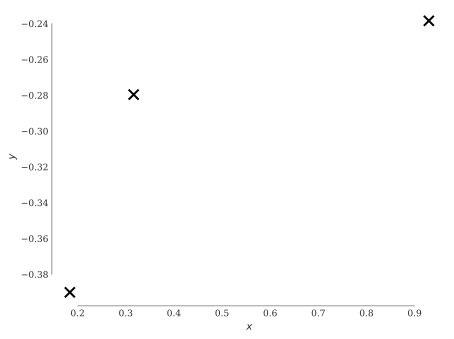

In [10]:
def f(x):
    """A function to optimize."""
    return -4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
sns.despine(trim=True);

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression, resulting in the point-predictive distribution:

$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$

where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

/Users/ibilion/.pyenv/versions/3.12.5/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/ibilion/.pyenv/versions/3.12.5/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


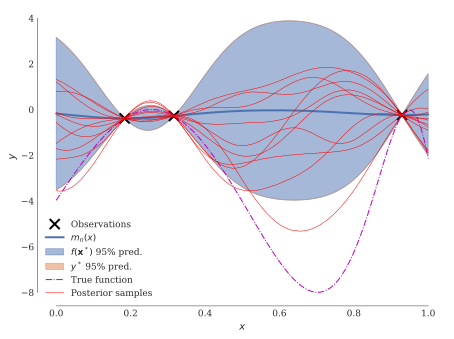

In [ ]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 1e-4
model.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(
    x,
    model,
    f_true=f
);

The expected improvement is more involved, but it serves as a template for deriving more general information acquisition functions.
Here is how you think.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best-observed point $y_n^*$?
It is:

$$
I_n(\mathbf{x}, y) =
\begin{cases}
0,&\;\text{if}\;y \le y_n^*,\\
y - y_n^*,&\;\text{otherwise}.
\end{cases}
$$

But you don't know what $y$ is. What do you do now?
Well, the only legitimate thing to do is to take the expectation over what you expected $y$ to be given what you know.
So it is:

$$
\begin{align}
\operatorname{EI}_n(\mathbf{x}) &=& 
\int_{-\infty}^\infty I_n(\mathbf{x}, y)p(y|\mathbf{x}, \mathcal{D}_n)dy\\
&=& \int_{-\infty}^{y_n^*}0\cdot p(y|\mathbf{x}, \mathcal{D}_n)dy
+ \int_{y_n^*}^{\infty}(y - y_n^*)\cdot p(y|\mathbf{x}, \mathcal{D}_n)dy.
\end{align}
$$

You can work this out analytically.
You will get:

$$
\operatorname{EI}_n(\mathbf{x}) = \left(m_n(\mathbf{x}) - y_n^*\right)\Phi\left(\frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\right)
+ \sigma_n(x)\phi\left(\frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\right).
$$

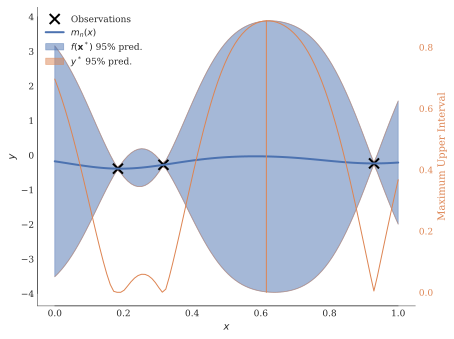

In [12]:
def ei(m, sigma, ymax):
    """Return the expected improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    diff = m - ymax
    u = diff / sigma
    ei = ( diff * torch.distributions.Normal(0, 1).cdf(u) + 
          sigma * torch.distributions.Normal(0, 1).log_prob(u).exp()
    )
    ei[sigma <= 0.] = 0.
    return ei

plot_iaf(
    x,
    model,
    ei
)

## Bayesian global optimization with the expected improvement

Let's now run the Bayesian global optimization algorithm using the expected improvement as the information acquisition function:

/Users/ibilion/.pyenv/versions/3.12.5/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


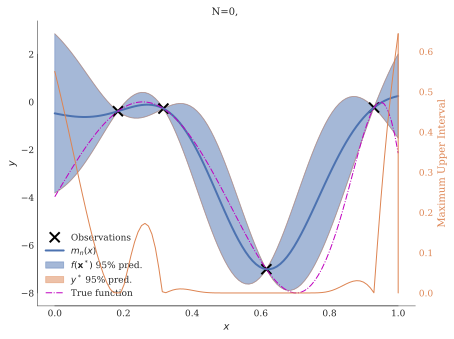

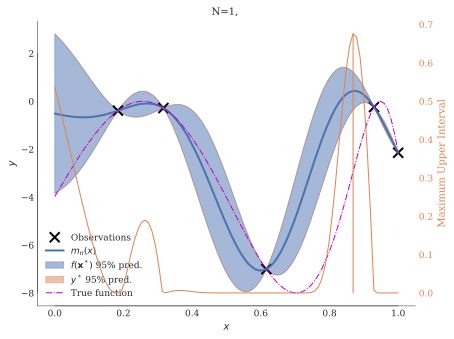

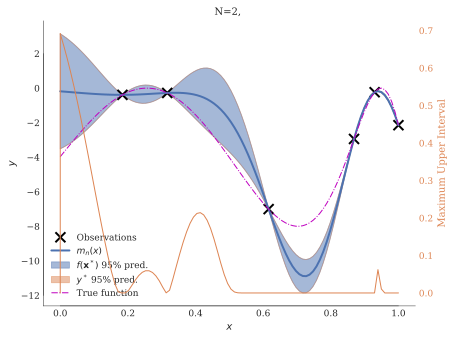

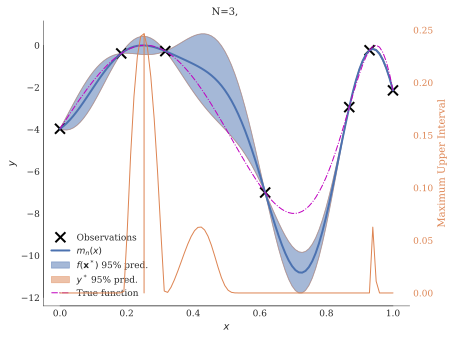

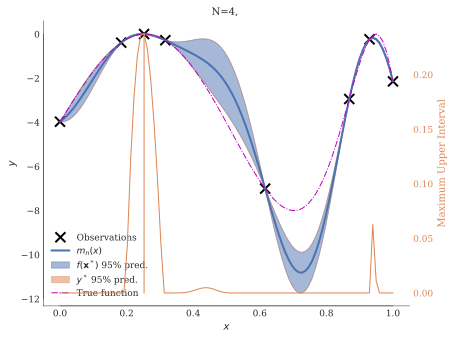

In [13]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.0
model.eval()

# Run the algorithm
X_design = torch.linspace(0, 1, 100)
af_all = maximize(
    f,
    model,
    X_design,
    ei,
    max_it=5,
    plot=1
)

### Questions

+ Rerun the main algorithm for EI by optimizing the hyper-parameters. Hint: Go through the code of ``maximize``.